## Preparar el entorno de trabajo

In [1]:
# HABILITAR GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Importar datos
import pandas as pd
import numpy as np
import glob

# Balancear la muestra
from imblearn.over_sampling import SMOTE

# Evaluar modelos y ajustar hiperparámetros
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Modelos
from sklearn.neighbors import KNeighborsClassifier

# Selección de características
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector
import matplotlib.pyplot as plt

# Preparar el modelo para producción
import seaborn as sns

# Exportar modelo
import pickle

## Importar los datos

In [3]:
# Lista para almacenar los DataFrames individuales
dfs = []

# Ruta a los archivos .csv
file_paths = glob.glob('/content/drive/MyDrive/Ciencia de datos e IA/archive/*.csv')

# Lectura de los .csv como DataFrames e incorporación a la lista
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenamiento de todos los DataFrames a uno solo
global_df = pd.concat(dfs, ignore_index=True)

# Descripción del DataFrame combinado
global_df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06,1.832560e+06
mean,-8.683814e-01,-3.178814e-02,2.244210e-02,-6.763959e-01,8.185066e-03,-3.858819e-01,3.940692e+00
std,2.756643e-01,1.556768e-01,4.279549e-01,5.596829e-01,2.707317e-01,5.087015e-01,2.912512e+00
min,-4.333252e+00,-2.031006e+00,-2.204834e+00,-7.942139e+00,-5.142578e+00,-7.593750e+00,1.000000e+00
25%,-9.909670e-01,-1.093750e-01,-2.692870e-01,-9.855960e-01,-1.132810e-01,-9.770510e-01,1.000000e+00
50%,-9.377440e-01,-1.855500e-02,-9.399400e-02,-9.357910e-01,-1.464800e-02,-1.906740e-01,3.000000e+00
75%,-8.344730e-01,5.761700e-02,3.078610e-01,-7.763700e-02,1.230470e-01,-3.174000e-03,7.000000e+00
max,3.630370e-01,1.576660e+00,1.179199e+00,3.395264e+00,5.725098e+00,3.953369e+00,8.000000e+00


In [4]:
# Crear un DataFrame para cada tipo de actividad
global_df_1 = global_df[(global_df['label'] == 1)]
global_df_3 = global_df[(global_df['label'] == 3)]
global_df_4 = global_df[(global_df['label'] == 4)]
global_df_5 = global_df[(global_df['label'] == 5)]
global_df_6 = global_df[(global_df['label'] == 6)]
global_df_7 = global_df[(global_df['label'] == 7)]
global_df_8 = global_df[(global_df['label'] == 8)]

# Crear un arreglo con todos los DataFrames
global_array = np.array([global_df_1, global_df_3, global_df_4, global_df_5, global_df_6, global_df_7, global_df_8])

<ipython-input-4-ab7247ef5c58>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  global_array = np.array([global_df_1, global_df_3, global_df_4, global_df_5, global_df_6, global_df_7, global_df_8])


## Preparar la muestra de conjuntos de prueba y de entrenamiento

In [5]:
# Número de muestras por actividad
n_size = 10000

# DataFrame para almacenar la muestra
sample_df = pd.DataFrame()

# Por cada DataFrame de actividades
for df in global_array:

  # Seleccionar todos los datos si es menos que 'n_size'
  if(df.shape[0] < n_size):
    selection = df
  # Seleccionar 'n_size' datos si es mayor que 'n_size'
  else:
    selection = df.sample(n=n_size)

  # Añadir al DataFrame correspondiente
  sample_df = pd.concat([sample_df, selection], axis=0)

# Almacenar la muestra como el DataFrame global
global_df = sample_df
print(global_df['label'].value_counts())

1    10000
3    10000
6    10000
7    10000
8    10000
5     4522
4     3726
Name: label, dtype: int64


In [6]:
# Identificar variables de prueba y de respuesta
x = global_df.iloc[:, 1:7].to_numpy()
y = global_df.iloc[:, 7].to_numpy()

# Equilibrar la distribución de los datos
smote = SMOTE()
x, y = smote.fit_resample(x, y)

# Número de plieges
n_folds = 5

# Crear divisor de datos para la validación cruzada
kf = StratifiedKFold(n_splits=n_folds, shuffle=True)

## K-Nearest Neighbor (No lineal)

In [7]:
# Arreglos para almacenar los valores reales y predicciones
cv_y_test = []
cv_y_pred = []
i = 1

# Repetir el proceso por cada pliege
for train_index, test_index in kf.split(x, y):

    # Imprimir el pliegue actual
    print(f'{i}/{n_folds} FOLDS:', end='')
    i += 1

    # Dividir datos en conjuntos de entrenamiento y de prueba
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(' SPLIT', end='')

    # Crear y entrenar el modelo con el conjunto de entrenamiento
    clf = KNeighborsClassifier()
    clf.fit(x_train, y_train)
    print(' - FIT', end='')

    # Probar el modelo con el conjunto de prueba
    y_pred = clf.predict(x_test)
    print(' - PRED', end='')

    # Almacenar los valores verdaderos y predicciones
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)
    print(' - SAVE')

# Evaluar el desempeño del modelo
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

1/5 FOLDS: SPLIT - FIT - PRED - SAVE
2/5 FOLDS: SPLIT - FIT - PRED - SAVE
3/5 FOLDS: SPLIT - FIT - PRED - SAVE
4/5 FOLDS: SPLIT - FIT - PRED - SAVE
5/5 FOLDS: SPLIT - FIT - PRED - SAVE
              precision    recall  f1-score   support

           1       0.74      0.61      0.67     10000
           3       0.63      0.57      0.60     10000
           4       0.81      0.92      0.86     10000
           5       0.78      0.82      0.80     10000
           6       0.77      0.83      0.80     10000
           7       1.00      1.00      1.00     10000
           8       1.00      1.00      1.00     10000

    accuracy                           0.82     70000
   macro avg       0.82      0.82      0.82     70000
weighted avg       0.82      0.82      0.82     70000



## Selección de características con el método Filter

F: 1 | A: 0.35019999999999996
F: 2 | A: 0.6008428571428571
F: 3 | A: 0.6869714285714286
F: 4 | A: 0.7545142857142857
F: 5 | A: 0.7894285714285715
F: 6 | A: 0.8195714285714286
Número óptimo de predictores: 6


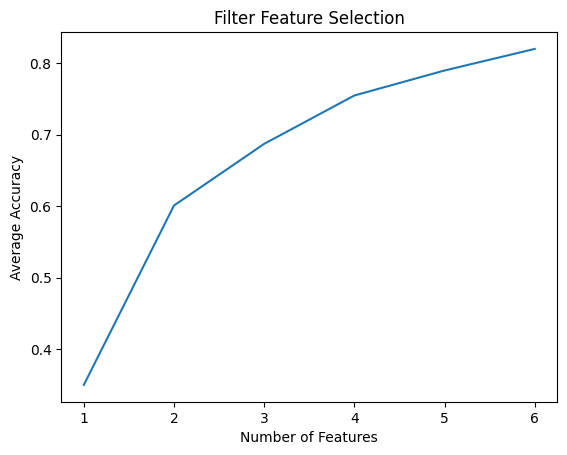

In [8]:
# Definir cada número de características posible
n_feats = [i for i in range(1, 7)]

# Arreglo para almacenar la exactitud de cada modelo
acc_nfeat = []

# Repetir el proceso por cada número de características
for n_feat in n_feats:

    # Arreglos para almacenar las exactitudes
    acc_cv = []

    # Repetir el proceso por cada pliege
    for train_index, test_index in kf.split(x, y):

        # Definir datos en el conjunto de entrenamiento
        x_train, x_test = x[train_index], x[test_index]

        # Encontrar las características óptimas para el conjunto de entrenamiento
        clf_cv = KNeighborsClassifier()
        fselection_cv = SelectKBest(f_classif, k=n_feat)
        fselection_cv.fit(x_train, y_train)

        # Entrenar el modelo con las características óptimas
        x_train = fselection_cv.transform(x_train)
        clf_cv.fit(x_train, y_train)

        # Probar el modelo con el conjunto de prueba
        x_test = fselection_cv.transform(x_test)
        y_test = y[test_index]
        y_pred = clf_cv.predict(x_test)

        # Almacenar la exactitud del modelo
        acc_i = accuracy_score(y_test, y_pred)
        acc_cv.append(acc_i)

    # Almacenar la exactitud promedio del modelo
    acc = np.average(acc_cv)
    acc_nfeat.append(acc)

    # Imprimir la exactitud promedio para cada número de características
    print('F:', n_feat, '| A:', acc)

# Imprimir el número óptimo de predictores
opt_index = np.argmax(acc_nfeat)
opt_features = n_feats[opt_index]
print('Número óptimo de predictores:', opt_features)

# Graficar la exactitud promedio para cada número de características
plt.plot(n_feats, acc_nfeat)
plt.title('Filter Feature Selection')
plt.xlabel('Number of Features')
plt.ylabel('Average Accuracy')
plt.show()

## Selección de características con el método Wrapper

F: 1 | A: 0.41847142857142855
F: 2 | A: 0.6005571428571429
F: 3 | A: 0.6908857142857143
F: 4 | A: 0.7556285714285714
F: 5 | A: 0.7989571428571429
Número óptimo de predictores: 5


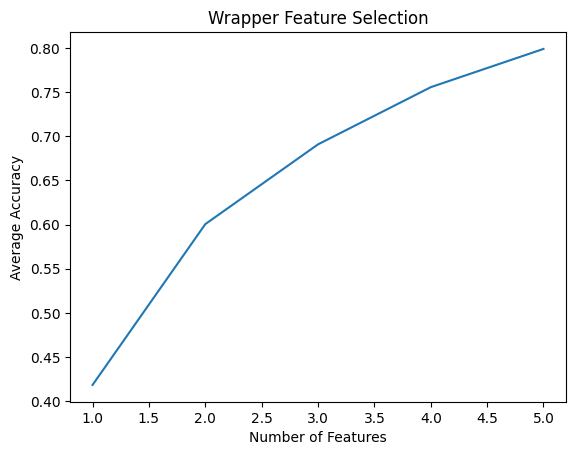

In [9]:
# Definir cada número de características posible
n_feats = [i for i in range(1, 6)]

# Arreglo para almacenar la exactitud de cada modelo
acc_nfeat = []

# Repetir el proceso por cada número de características
for n_feat in n_feats:

    # Arreglos para almacenar las exactitudes
    acc_cv = []

    # Repetir el proceso por cada pliege
    for train_index, test_index in kf.split(x, y):

        # Definir datos en el conjunto de entrenamiento
        x_train, x_test = x[train_index], x[test_index]

        # Encontrar las características óptimas para el conjunto de entrenamiento
        clf_cv = KNeighborsClassifier()
        fselection_cv = SequentialFeatureSelector(clf_cv, n_features_to_select=n_feat)
        fselection_cv.fit(x_train, y_train)

        # Entrenar el modelo con las características óptimas
        x_train = fselection_cv.transform(x_train)
        clf_cv.fit(x_train, y_train)

        # Probar el modelo con el conjunto de prueba
        x_test = fselection_cv.transform(x_test)
        y_test = y[test_index]
        y_pred = clf_cv.predict(x_test)

        # Almacenar la exactitud del modelo
        acc_i = accuracy_score(y_test, y_pred)
        acc_cv.append(acc_i)

    # Almacenar la exactitud promedio del modelo
    acc = np.average(acc_cv)
    acc_nfeat.append(acc)

    # Imprimir la exactitud promedio para cada número de características
    print('F:', n_feat, '| A:', acc)

# Imprimir el número óptimo de predictores
opt_index = np.argmax(acc_nfeat)
opt_features = n_feats[opt_index]
print('Número óptimo de predictores:', opt_features)

# Graficar la exactitud promedio para cada número de características
plt.plot(n_feats, acc_nfeat)
plt.title('Wrapper Feature Selection')
plt.xlabel('Number of Features')
plt.ylabel('Average Accuracy')
plt.show()

## Ajuste de hiperparámetros

In [10]:
# Definir los parametros a probar
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'weights': ['uniform', 'distance'], 'p': [1, 2]}

# Arreglos para almacenar los valores reales y predicciones
cv_y_test = []
cv_y_pred = []

# Repetir el proceso por cada pliege
for train_index, test_index in kf.split(x, y):

    # Dividir datos en conjuntos de entrenamiento y de prueba
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Crear un modelo con los parámetros óptimos y entrenarlo con el conjunto de entrenamiento
    clf_cv = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
    clf_cv.fit(x_train, y_train)

    # Probar el modelo con el conjunto de prueba
    y_pred = clf_cv.predict(x_test)

    # Almacenar los valores verdaderos y predicciones
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)

# Evaluar el desempeño del modelo
print(clf_cv.best_estimator_)
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

KNeighborsClassifier(n_neighbors=4, weights='distance')
              precision    recall  f1-score   support

           1       0.76      0.61      0.68     10000
           3       0.63      0.56      0.59     10000
           4       0.87      0.96      0.91     10000
           5       0.82      0.91      0.86     10000
           6       0.75      0.82      0.78     10000
           7       1.00      1.00      1.00     10000
           8       1.00      1.00      1.00     10000

    accuracy                           0.84     70000
   macro avg       0.83      0.84      0.83     70000
weighted avg       0.83      0.84      0.83     70000



## Preparar el modelo para producción

In [11]:
# Concatenamiento de todos los DataFrames a uno solo
global_df = pd.concat(dfs, ignore_index=True)

# Identificar variables de prueba y de respuesta
x = global_df.iloc[:, 1:7].to_numpy()
y = global_df.iloc[:, 7].to_numpy()

# Equilibrar la distribución de los datos
smote = SMOTE()
x, y = smote.fit_resample(x, y)

# Definir el modelo para producción
clf = clf_cv.best_estimator_

In [12]:
# Evaluar el desempeño del modelo con validación cruzada
y_pred = cross_val_predict(clf, x, y, cv=5)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.68      0.81    869690
           3       0.86      1.00      0.92    869690
           4       0.97      1.00      0.99    869690
           5       0.96      1.00      0.98    869690
           6       0.91      0.98      0.94    869690
           7       1.00      1.00      1.00    869690
           8       1.00      1.00      1.00    869690

    accuracy                           0.95   6087830
   macro avg       0.96      0.95      0.95   6087830
weighted avg       0.96      0.95      0.95   6087830



Text(0.5, 1.0, 'Confusion matrix')

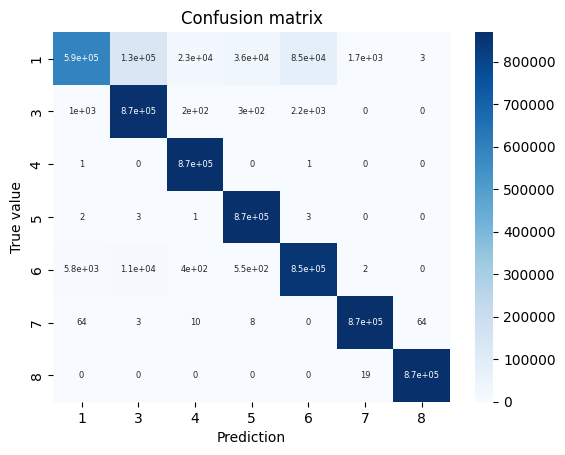

In [13]:
# Crear la matriz de confusión
c_m = confusion_matrix(y, y_pred)

# Graficar la matriz de confusión
sns.heatmap(c_m, annot=True, annot_kws={"size": 6}, cmap='Blues',
            xticklabels=['1', '3', '4', '5', '6', '7', '8'],
            yticklabels=['1', '3', '4', '5', '6', '7', '8'])
plt.ylabel('True value')
plt.xlabel('Prediction')
plt.title('Confusion matrix')

## Exportar modelo

In [17]:
with open('/content/drive/MyDrive/Ciencia de datos e IA/k_nearest_neighbors_model.pkl', 'wb') as f:
  pickle.dump(clf, f)